The following code is based on: 
    https://github.com/PetraVidnerova/rbf_keras
    https://keras.io/layers/writing-your-own-keras-layers/

In [1]:
import tensorflow as tf

import numpy as np

import pandas as pd

import os

import matplotlib.pyplot as plt 
%matplotlib inline

import gzip
import _pickle as cPickle

import sklearn
from sklearn import datasets
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale


from IPython import display

from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras import backend as K
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Orthogonal, Constant
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

import math
import random 
import time


Using TensorFlow backend.


In [2]:
# imports for array-handling and plotting
from keras.datasets import mnist

n_classes = 10
def load_data():

    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
        
    # Normalizing the input data to max=1 helps to speed up the training. 
    # reshape each image to 1D vector for simplicity
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    v_len = X_train.shape[1]*X_train.shape[2]    
    
    X_train = X_train.reshape(n_train, v_len)
    X_test = X_test.reshape(n_test, v_len)
    
    # normalizing the data to help with the training. accurancy is lower than sklearn.preprocessing.scale
    """
    max_pixel = np.max(X_train)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= max_pixel
    X_test /= max_pixel
    """
    #using sklearn.preprocessing.scale, leads to higher accuracy than normalization by max as above
    X_train = scale(X_train)
    X_test = scale(X_test)

    
    #Do it only when the final layers output is, e.g. 10
    # one-hot encoding using keras' numpy-related utilities
    print("Shape before one-hot encoding: ", Y_train.shape)
    Y_train = np_utils.to_categorical(Y_train, n_classes)
    Y_test = np_utils.to_categorical(Y_test, n_classes)
    print("Shape after one-hot encoding: ", Y_train.shape)
    
    return X_train, Y_train, X_test, Y_test

C:\Users\wxie\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


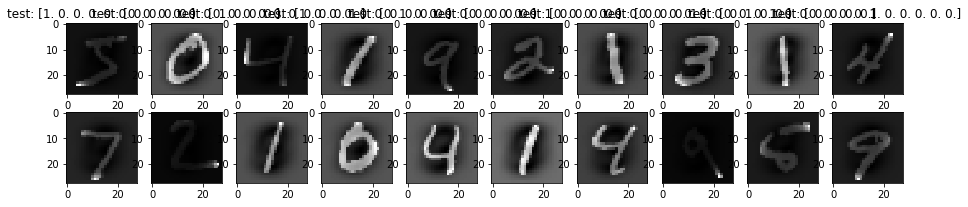

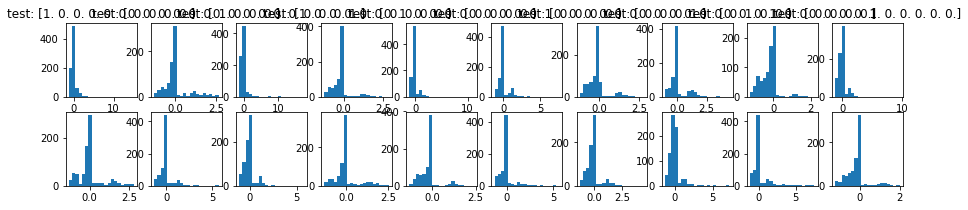

In [3]:
# load the data sets
X_train, Y_train, X_test, Y_test = load_data() 

#check if still produce images
fig, axes = plt.subplots(2,10,figsize=(15, 3))
for i in range(20):
    if(i<10):
        a = X_train[i].reshape(28, 28)
        axes[0, i].imshow(a, cmap='gray', interpolation='none')
        axes[0, i].set_title("train: {}".format(Y_train[i]))

    else: 
        a = X_test[i-10].reshape(28, 28)
        axes[1, i-10].imshow(a, cmap='gray', interpolation='none')
        axes[0, i-10].set_title("test: {}".format(Y_test[i]))

#check the 1-D distribution of each image        
fig, axes = plt.subplots(2,10,figsize=(15, 3))
for i in range(20):
    if(i<10):
        axes[0, i].hist(X_train[i], bins=20)
        axes[0, i].set_title("train: {}".format(Y_train[i]))

    else: 
        axes[1, i-10].hist(X_test[i], bins=20)
        axes[0, i-10].set_title("test: {}".format(Y_test[i]))

In [4]:
#initializer for RBF
class InitCentersKmean(Initializer):
    """ Initializer for initialization of centers of RBF network
        using K-mean.

    # Arguments
        X: matrix, dataset to choose the centers from (random rows 
          are taken as centers)
    """
    def __init__(self, X):
        self.X = X
        print("_____ initializing center using InitCentersKmean _____")

    def __call__(self, shape, dtype=None):
        # "shape" is the input_shape for "self.add_weigh" down below
        self.center = sklearn.cluster.k_means(self.X, init='random', n_clusters=shape[0], max_iter = 1, n_jobs=-1)
        
        return self.center[0]

In [5]:
from scipy.spatial import distance
#the custom RBF layer        
class RBFLayer(Layer):
    """ Layer of Gaussian RBF units. 

    # Example
 
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X), 
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    

    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas 

    """
   
    def __init__(self, output_dim, initializer=InitCentersKmean, betas=1.0, **kwargs):
        self.output_dim = output_dim # dim of the layer's output, i.e. in this case: number of centers in this layer
        self.init_betas = betas 
        self.initializer = initializer 

        super().__init__(**kwargs) #python3 format

    def build(self, input_shape): # input shape is the shape from output of last layers. in this case, it's data: [?, 784]
        self.centers = self.add_weight(name='centers', 
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,), 
                                     initializer=Constant(value=self.init_betas),
                                     trainable=True)
        
        super().build(input_shape) #python3
     
    def call(self, x):

        C=K.expand_dims(self.centers) # shape (ncenter, 784, 1) for broadcast
        H = K.transpose(C-K.transpose(x)) # K.transpose(x) shape (784, ?), then this shape: 

        """
        # the following printout is used for debugging purpose
        print("self.centers.shape: ", self.centers.shape)
        print("x.shape", x.shape)
        print("K.transpose(x).shape: ", K.transpose(x).shape)
        print("C.shape: ", C.shape)
        print("H.shape: ", H.shape)
        print("self.betas.shape: ", self.betas.shape)
        print("K.sum(H**2, axis=-2).shape: ", K.sum(H**2, axis=-2).shape)
        print("call return shape: ", K.exp( -self.betas * K.sum(H**2, axis=-2)).shape)
        """
        a = K.exp( -K.sum(H**2, axis=-2)/(2*self.betas*self.betas))
        
        return a
             

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        #base_config = super(RBFLayer, self).get_config()
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
# now build the model and run the training 

model = Sequential()

n_center = 10
one_sample_shape = X_train.shape[-1] # shape for each individual sample

rbflayer = RBFLayer(n_center,
                    initializer=InitCentersKmean(X_train), 
                    betas=20,
                    # input_shape is the data shape. The 2nd dim of (one_sample_shape, ) is the number of samples and is treated as ? in keras
                    input_shape=(one_sample_shape, )) 

model.add(rbflayer)
model.add(Dense(n_classes))
model.add(Activation('softmax'))

model.summary()

_____ initializing center using InitCentersKmean _____
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer_1 (RBFLayer)       (None, 10)                7850      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


In [7]:
#need to build the model first before loading the weights. 
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Load weights into the new model
model.load_weights('results/RBF_weights.h5')


In [8]:
loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

Test Loss 1.0050245316505433
Test Accuracy 0.7518
